---
layout: article
title: cmos variable state filter
author: spielhuus
tags: cmos
category: article
logo: cmos_variable_state_files/cd4069.jpg
excerpt: the cd4069 cmos chip is . there are already filter designs with the CD4069. the most popular one is the WASP filter clone from jürgen haible. this filter adds a lot of distortion to the sound.
---


[1]: https://www.ti.com/lit/ds/schs054e/schs054e.pdf

In [2]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'
%load_ext itikz

#%matplotlib widget
#import ipywidgets as widgets
#from ipywidgets import *
#from ipywidgets.embed import embed_minimal_html

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

## buffer

the simplest circuit to begin with is a voltage buffer. while buffers with opamps are relatively easy, with the cmos chips the input and output impedence are important. 

The gain of a cmos buffer is

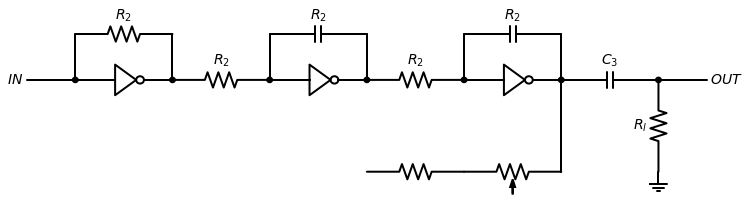

In [15]:
d = schemdraw.Drawing()

d.add(elm.Line('right', l=d.unit/2, lftlabel='$IN$'))
N1 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_2$'))
N2 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_2$'))
N3 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_3$'))
d.add(elm.Resistor("down",label='$R_l$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N3.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Capacitor('right', label='$R_2$'))
d.add(elm.Line('down', l=d.unit/2))
D = d.add(logic.Dot())

d.add(elm.Line('down', l=d.unit, xy=D.start))
d.add(elm.Potentiometer('left'))
d.add(elm.Resistor('left'))

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2, rgtlabel='$OUT$'))
#d.add(elm.Line('right', l=d.unit, rgtlabel='$OUT$'))

d.draw()

In [4]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ);

In [5]:
buffer_data = []
for r in np.arange(100@u_kΩ, 200@u_kΩ, 25@u_kΩ):
    circuit.R2.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_Hz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data.append(np.array(analysis['OUT']));

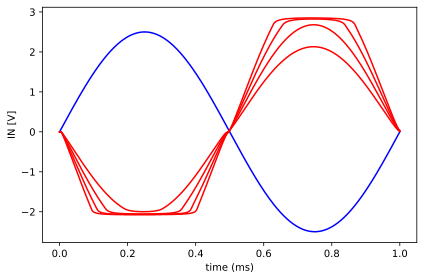

In [6]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
ax1.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Blue')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[0], color='Red')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[1], color='Red')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[2], color='Red')
ax1.plot(u_ms(analysis['OUT'].abscissa), buffer_data[3], color='Red')

#def buffer_update(w =(100, 200, 1)):
#    out_line.set_ydata(buffer_data[w-100])
#    fig.canvas.draw()
#interact(buffer_update);

plt.tight_layout()
plt.show()

## *references*

- [CD4069][1] Datasheet
